# How to create an executable statistical report

_Max Schröder_ and _Frank Krüger_

(this notebook is heavily based on the statistical report from Anja Eggert but translated to Python. The original report is available from: https://github.com/AnjaEggert/ords-kick-off)

2020-12-01

Specify the parameters of the notebook at the very beginning. This notebook has the following parameters:
 * `kmeans_k` which controls the number of components for clustering

In [1]:
kmeans_k = 2

## Load required packages

All required packages are loaded at the begin of the notebook to provide an overview of the requirements. For most data science and/or statistical analysis, we need packages from the following four groups:
 * data handling
 * statistical analysis
 * data transformation and machine learning
 * visualization

In [2]:
# general data handling
import numpy as np
import pandas as pd


# statistics
from scipy import stats
from statsmodels.stats.multitest import multipletests


# basic math function
import math

# machine learning, data transformation
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

# visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Read and inspect data

### Data set description
Shotgun lipidomics was applied and 335 single metabolites were measured in two experimental groups with 14 samples in the control group and 14 samples in the treatment group. The single metabolites can be assigned to 15 lipid classes.

Lipid concentrations are given normalized to total lipids: nmol/mg lipid.

**Aim**: Detect significant differences between groups of single fatty acid metabolites (or sum of metabolites).

### Load data

Data is often saved in Excel files. This has several disadvantages with respect to data quality (see http://www.eusprig.org/horror-stories.htm). For the time being, we ignore disadvantages and just load the data by using the `pandas` function `read_excel`. After loading an overview of the first 10 rows and 6 columns is provided. 

In [3]:
data = pd.read_excel('Rmarkdown-workshop/data/data-lipidomics-28samples.xlsx')
data.iloc[:10,:6]

,sample,group,LEG in kg,ADFI in g,PC 14:0_16:0,PC 14:0_18:2
0,1,k,96.9,2307.4,0.327597,0.542359
1,2,k,104.7,2496.5,0.232461,0.537308
2,3,k,110.5,2817.3,0.188939,0.642418
3,4,k,91.8,2182.6,0.315606,0.607394
4,5,k,98.0,2389.4,0.342605,0.932198
5,6,k,95.3,2175.3,0.346377,0.845904
6,7,k,90.7,2126.0,0.352771,0.844983
7,8,k,99.9,2525.3,0.244824,0.745240
8,9,k,109.9,2450.4,0.289473,0.889802
9,10,k,108.9,2616.3,0.288564,0.642161


### Data preprocessing

The following preprocessing steps are done:
* Recode the factors to improve comprehensibility
* Remove invalid measurements such as `0` and `NA`'s
* Transform data table from wide to long format
* Select variables of interest (here, remove the summary variables, as we will do this on ourselves)

Some recommendations for working with spreadsheets are given here: https://doi.org/10.1080/00031305.2017.1375989

In [4]:
# rename groups 'k' and 'v'
data = data.replace({'group': {'k':'control', 'v':'treatment'}})
# replace '0' and 'na' by 0.001
data = data.mask(data==0).fillna(0.001)

# convert to long format
data = pd.melt(data, id_vars=['group','sample','LEG in kg','ADFI in g'], var_name='lipid', value_name='concentration')

# take 'real' lipids only
data = data[data['lipid'].str.contains(":")]
data

,group,sample,LEG in kg,ADFI in g,lipid,concentration
0,control,1,96.9,2307.4,PC 14:0_16:0,0.327597
1,control,2,104.7,2496.5,PC 14:0_16:0,0.232461
2,control,3,110.5,2817.3,PC 14:0_16:0,0.188939
3,control,4,91.8,2182.6,PC 14:0_16:0,0.315606
4,control,5,98.0,2389.4,PC 14:0_16:0,0.342605
...,...,...,...,...,...,...
9795,treatment,24,92.5,1953.2,LPG 18:1,0.090964
9796,treatment,25,85.6,2011.7,LPG 18:1,0.107179
9797,treatment,26,101.8,2402.4,LPG 18:1,0.101568
9798,treatment,27,90.1,2058.6,LPG 18:1,0.050705


### Data summary

Take a quick look at the mean and standard deviation of all measurements from the different groups to get a first intuition of the data.

In [5]:
data.groupby(['lipid','group']).agg({'concentration' : ['mean','std']})

concentration          
                                 mean       std
lipid         group                            
CL 72:8       control        0.867482  0.281953
              treatment      0.885385  0.313753
Cer 18:1/18:0 control        1.086309  0.289239
              treatment      0.999366  0.342935
DAG 16:0_16:1 control        0.168877  0.061998
...                               ...       ...
TAG 58:6      treatment      2.339417  0.622380
TAG 58:7      control        0.298150  0.083205
              treatment      4.019599  1.468739
TAG 58:8      control        0.449591  0.119082
              treatment      8.410113  1.535648

[670 rows x 2 columns]

### Data visualisation

It is always a good idea to plot the data in addition to inspecting the raw data. Here, we review the group differences of all measurements by box plots.

No handles with labels found to put in legend.


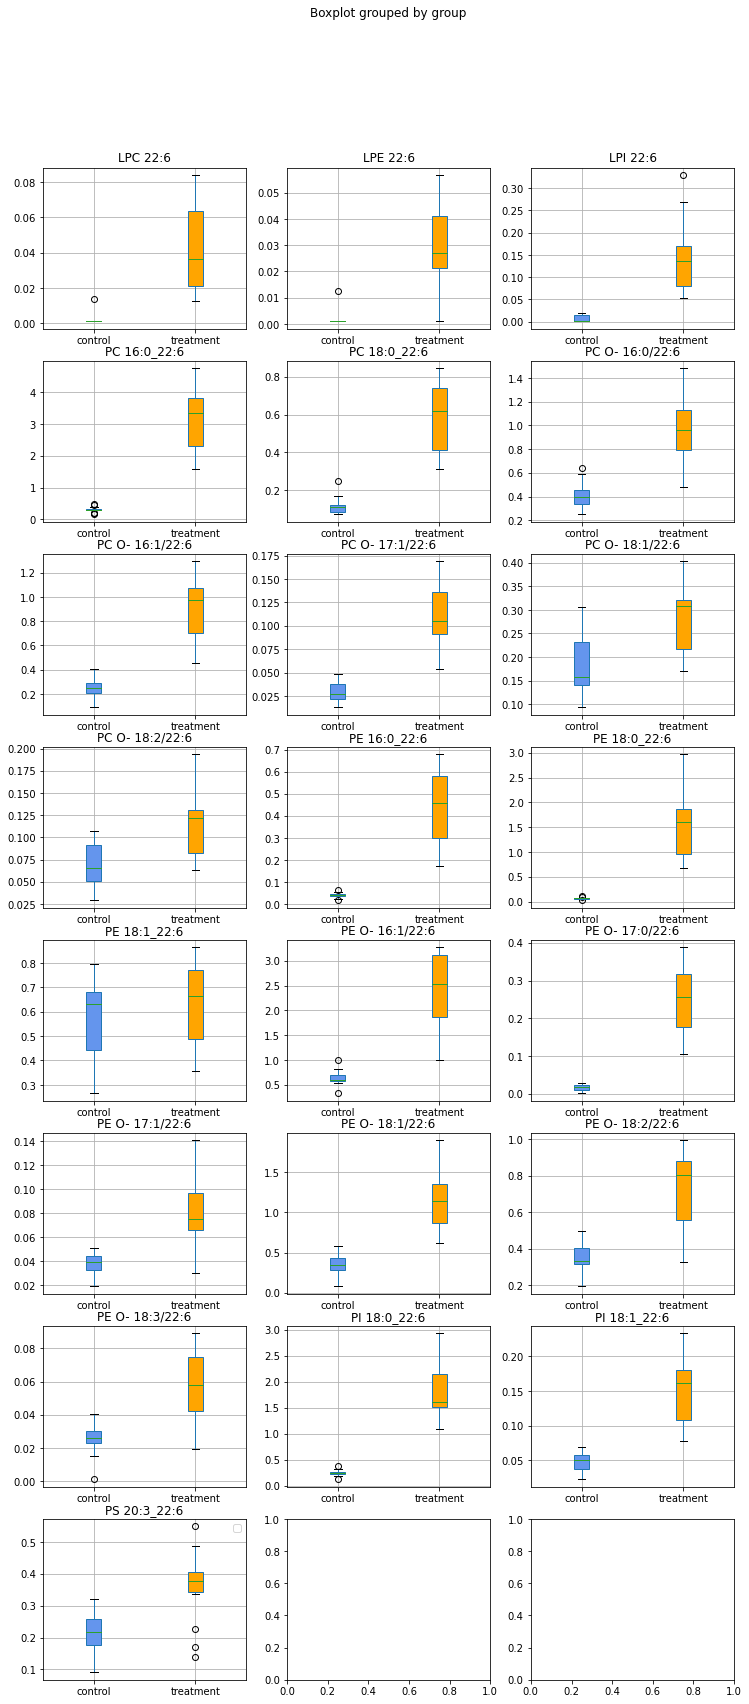

In [6]:
grouped = data.loc[data['lipid'].str.contains("22:6"), ['lipid', 'group', 'concentration']].groupby('lipid')

ncols=3
nrows = int(math.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,28)) #, sharey=True)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    tmp = grouped.get_group(key).boxplot(by='group', ax=ax, return_type='both', patch_artist=True)
    for row_key, (ax,row) in tmp.iteritems():
        ax.set_title(key)
        ax.set_xlabel('')
    
        colors = ['cornflowerblue', 'orange']
        for i,box in enumerate(row['boxes']):
            box.set_facecolor(colors[i])

ax.legend()
plt.show()

## Data analysis

### Compare groups

Metabolomics data often have a log-normal distribution, i.e. the log(data) is normally distributed. We just assume this here (without any test).

We extract the p-values from the test results. 

In [7]:
data_per_lipid = {x:y for x, y in data.groupby('lipid', as_index=False)}

p_values = pd.DataFrame(columns=["lipid", "p_ttest_log", "p_wil"])

for lipid, df in data_per_lipid.items():
    p_ttest_log = stats.ttest_ind(np.log(df[df['group']=='control']['concentration']),
                    np.log(df[df['group']=='treatment']['concentration'])).pvalue
    
    p_wil = stats.mannwhitneyu(df[df['group']=='control']['concentration'],
                          df[df['group']=='treatment']['concentration']).pvalue
    
    p_values = p_values.append({
     "lipid": lipid,
     "p_ttest_log":  p_ttest_log,
     "p_wil" : p_wil
      }, ignore_index=True)
    
p_values

,lipid,p_ttest_log,p_wil
0,CL 72:8,9.570071e-01,0.314743
1,Cer 18:1/18:0,3.564203e-01,0.210674
2,DAG 16:0_16:1,2.368264e-01,0.197654
3,DAG 16:0_18:1,6.554461e-01,0.382600
4,DAG 16:0_18:2,4.756618e-01,0.210674
...,...,...,...
330,TAG 56:8,3.218940e-18,0.000004
331,TAG 58:5,9.165438e-10,0.000004
332,TAG 58:6,1.884576e-18,0.000004
333,TAG 58:7,9.717456e-19,0.000004


#### Some necessary background information about multiple statistical tests and correction
p-values are random variables. Mathematically, one can demonstrate that under the null hypothesis (and some assumptions are met, in this case, the test statistic t follows standard normal distribution), p-values follow a uniform (0,1) distribution. How do we control the false positives for multiple comparisons? One way is to use the Bonferroni correction to correct the familywise error rate (FWER): define a particular comparison as statistically significant only when the P value is less than alpha (often 0.05) divided by the number of comparisons:

$$ p < \frac{\alpha}{m} $$

This approach is very conservative and this threshold will be very small the more comparisons are made. The “BH” (aka “fdr”) method of Benjamini, Hochberg control the false discovery rate, the expected proportion of false discoveries amongst the rejected hypotheses. The false discovery rate is a less stringent condition than the family-wise error rate, so these methods are more powerful than the others. 

### Distribution of p-values
Here, we made 335 comparisons, i.e. 335 individual tests were performed. Have a look at the distribution of the p- values.

array([[<AxesSubplot:title={'center':'p_ttest_log'}>,
        <AxesSubplot:title={'center':'p_wil'}>]], dtype=object)

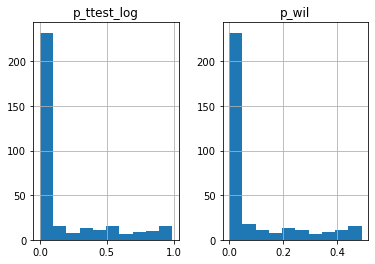

In [8]:
p_values.hist()

### Correction for multiple tests
There are 222 of the 335 lipids with a p-value < 0.05, have all of them statistically different concentrations in treatment vs. control? NO! We need to limit the family-wise error rate, one approach is to apply the Bonferroni adjustment, i.e. to decrease the individual error rate to:

$$ p < \frac{\alpha}{m} = \frac{0.05}{335}=0.000149 $$

However, here we control the False Discovery Rate (FDR) and limit the number of false positives to some value.

We can use a function `multipletests` from the `statsmodels` package.

In [9]:
p_values['p_ttest_log_corrected'] = multipletests(p_values['p_ttest_log'], method='fdr_bh')[1]
p_values

,lipid,p_ttest_log,p_wil,p_ttest_log_corrected
0,CL 72:8,9.570071e-01,0.314743,9.632615e-01
1,Cer 18:1/18:0,3.564203e-01,0.210674,4.592338e-01
2,DAG 16:0_16:1,2.368264e-01,0.197654,3.160831e-01
3,DAG 16:0_18:1,6.554461e-01,0.382600,7.418055e-01
4,DAG 16:0_18:2,4.756618e-01,0.210674,5.752588e-01
...,...,...,...,...
330,TAG 56:8,3.218940e-18,0.000004,1.797241e-16
331,TAG 58:5,9.165438e-10,0.000004,4.582719e-09
332,TAG 58:6,1.884576e-18,0.000004,1.262666e-16
333,TAG 58:7,9.717456e-19,0.000004,8.138369e-17


In [10]:
kmeans = KMeans(n_clusters=kmeans_k, n_init=25, init='random', algorithm='full', random_state=42)


data_to_cluster = pd.pivot_table(data[['sample','group','lipid','concentration']], 
                                 index=['sample','group'], 
                                 columns=['lipid'])
data_to_cluster.reset_index(level=['group','sample'], inplace=True)
data_to_cluster.values[:,2:]

array([[0.6873220001380118, 0.8758193254311857, 0.132841876794624, ...,
        0.18725506647032342, 0.19076988022243835, 0.19838965732563132],
       [0.557629401385373, 0.7849163433744979, 0.09560754116477324, ...,
        0.28920135722879725, 0.3029633710117057, 0.3995350355839375],
       [0.309768551545788, 0.8241604814430419, 0.07145489275594194, ...,
        0.3639255573719691, 0.4984084055726741, 0.5528439807885388],
       ...,
       [0.8206503497563161, 1.0678818116582771, 0.13351472002707587, ...,
        1.9865598857018878, 3.2513814693560232, 6.814896756496571],
       [0.47935270565126686, 0.5535969215973086, 0.19350926074119412,
        ..., 2.3155811333330005, 2.533736634336631, 8.879702876467444],
       [1.0237093156853068, 1.1440104053222657, 0.14028967092285155, ...,
        2.1731064794741366, 3.904729151054418, 8.721880964463447]],
      dtype=object)

In [11]:
data_to_cluster['cluster'] = kmeans.fit_predict(data_to_cluster.values[:,2:])

data_to_cluster[['group','cluster']]

,group,cluster
lipid,,
0,control,1
1,control,1
2,control,0
3,control,1
4,control,1
5,control,1
6,control,1
7,control,0
8,control,0


### Cluster visualization

To effectively visualize, whether the clustering allows us for some unsupervised grouping, we reduce the number of dimension to 2, which allows us to use a 2-dimensional scatter plot. To this end, we use a principal component analysis and select the two dimension that contain the highest variance. These dimensions are then plotted against each other.

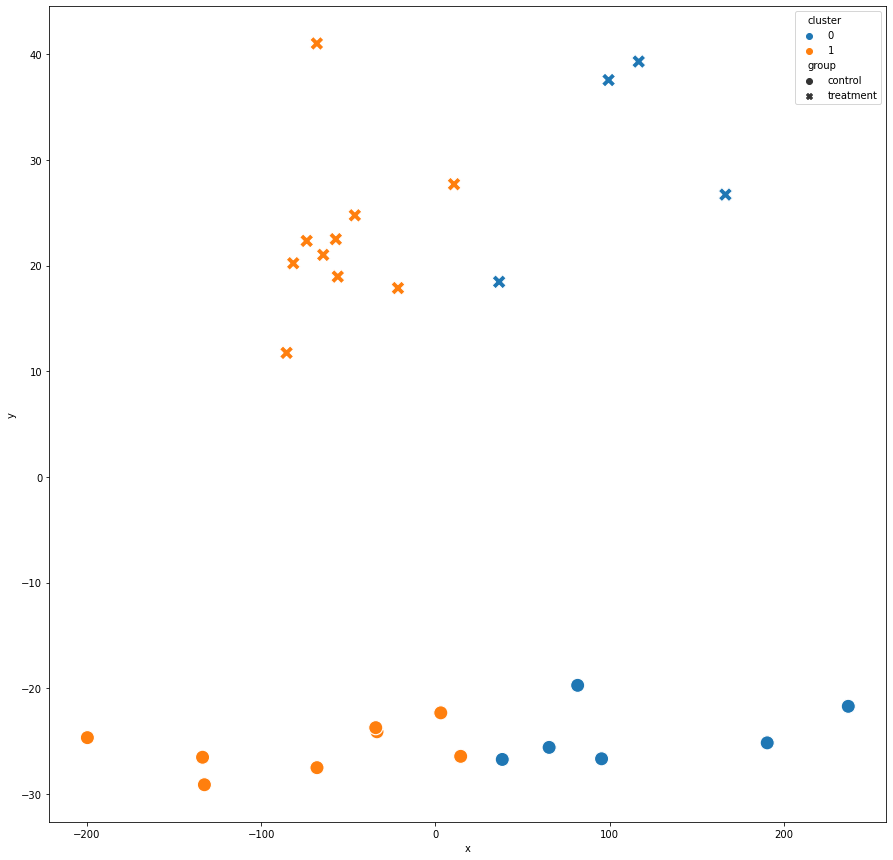

In [12]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_to_cluster.values[:,2:])

df_transformed = pd.DataFrame(data_pca, columns=['x', 'y'])
df_transformed['cluster'] = list(data_to_cluster['cluster'])
df_transformed['group'] = list(data_to_cluster['group'])
df_transformed


plt.figure(figsize=(15, 15))
ax = sns.scatterplot(data=df_transformed, x="x", y="y", hue="cluster", style='group', s=200)

### Conclusion
From the plot, two observations can be found:
* both groups `control` and `treatment` can be distinguished, and
* the `kmeans` clustering did not find this grouping, but another

We could now use supervised learning and feature selection approaches to identify the measurements that provide us the most important differences. However, as this notebook is just for demonstration purposes, we leave this for the interested reader. 😉